# Tests of cross_appr module:
    calculate function's values tensor on the multidimensional Chebushev mesh
    in TT format by cross approximation method.
    
    After tensor's construction the function is interpolated by
    Chebyshev polynomials.

# Function for approximation and interpolation:

$$ f(x) = 1 + e^{-0.5} x^2_1sin(c_1) + e^{-1} x^3_2 sin(2c_2) + \sum_{k=3}^{n} e^{-0.5k} x_k sin(k c_k); \;\; c=const, \; n>2 $$

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
import sys

import tt

sys.path.append('./../../../parametric_pdes/sde')
from cross_appr.sparse_array import SparseArray
from cross_appr import cross_appr as cr_appr
from chebushev import chebushev_tt as ch_tt
print "----------------------------------- OK ----- All modules are imported"

from qttpdesolver import Func, Vector

def func(r, c):
    k = np.arange(len(r), dtype=float)+1.
    l = np.exp(-0.5*k)
    f = l*r*np.sin(k*c)
    f[0]*= r[0]
    f[1]*= r[1]*r[1]
    return 1. + np.sum(f)

----------------------------------- OK ----- All modules are imported


# Parameters of the calculation:

In [2]:
n_dim = 10
c = np.ones(n_dim)
n_poi_cr = np.array([8]*n_dim)
x_lim_cr = np.array([[-3., 3.]]*n_dim)
tol_cr = 1.E-7; tol_tt = 1.E-7
file_log = './cross_appr_log.txt'

# Cross approximation:

In [3]:
Time = time.time()
f = func; f_args = [c]
Y, calc_num, cr_info = cr_appr.calculate_tensor(f, f_args, n_poi_cr, 
                                                x_lim_cr, tol_cr, file_log)
cr_iter, cr_err_rel, cr_err_abs, cr_e_rank = cr_info
print "Number of function's calculations: ", calc_num
print "               * full tensor size: ", np.prod(np.array(n_poi_cr))
print "Ranks of Y tensor                : ", Y.r
print "Average tensor's ranks           : ", cr_e_rank
print "Number of cross iterations       : ", cr_iter
print "Relative error of approximation  : ", cr_err_rel
print "Absolute error of approximation  : ", cr_err_abs
G = tt.tensor.to_list(Y); 
Ysize = 0; 
for GG in G: Ysize += GG.size
print "Total size of Y cores            : ", Ysize
print '----------------------'
print 'Total time %6.3f sec. '%(time.time() - Time)

Number of function's calculations:  5647
               * full tensor size:  1073741824
Ranks of Y tensor                :  [ 1  9 10  9 10 10  9  9 10  8  1]
Average tensor's ranks           :  9.4
Number of cross iterations       :  2
Relative error of approximation  :  3.4e-13
Absolute error of approximation  :  7.7e-08
Total size of Y cores            :  5824
----------------------
Total time  0.633 sec. 


In [4]:
F = Func(n_dim, isXYZ=False).set_func(func).set_args(c=c)
Y = F.buildt(n_poi_cr, x_lim_cr, eps=tol_cr, F0=None, verb=True, i0=0)

Cross evals    :  7744    
Function evals :  5831    
TT cores size  :  5392    
TT ranks       :  [ 1  9  9  9  9  9 10  9  9  8  1]    
Eff TT rank    :  9.1   
Iters          :  2    
Err rel        :  1.20e-12
Err abs        :  2.80e-07
Total time (s) :  0.547 



In [5]:
def func1(x, y, z, w):
    return x*y*z*w

X = Vector.ones(3, 'tt', 1.E-8) + Vector.arange(3, 'tt', 1.E-8)
Y = Vector.ones(3, 'tt', 1.E-8) + Vector.arange(3, 'tt', 1.E-8) * 2.
Z = Vector.ones(3, 'tt', 1.E-8) + Vector.arange(3, 'tt', 1.E-8) * 3.
F = Func(3).set_func(func1).set_args(w=2)
Y = F.build([X, Y, Z], inv=True, verb=True)
print Y.to_np

  Construction of func
TT cores size  :  16    
TT ranks       :  [1 2 2 1]    
Eff TT rank    :  2.0   
Iters          :  2    
Max dy         :  1.43e-17
Total time (s) :  0.010 

[  5.00000000e-01   2.08333333e-02   4.76190476e-03   1.78571429e-03
   8.54700855e-04   4.73484848e-04   2.89184500e-04   1.89393939e-04]


['swp: 0/9 er_rel = 1.0e+00 er_abs = 2.3e+05 erank = 5.0 fun_eval: 1248\n', 'swp: 1/9 er_rel = 1.2e-12 er_abs = 2.8e-07 erank = 9.1 fun_eval: 7744\n']
This is a 10-dimensional tensor 
r(0)=1, n(0)=8 
r(1)=9, n(1)=8 
r(2)=9, n(2)=8 
r(3)=9, n(3)=8 
r(4)=9, n(4)=8 
r(5)=9, n(5)=8 
r(6)=10, n(6)=8 
r(7)=9, n(7)=8 
r(8)=9, n(8)=8 
r(9)=8, n(9)=8 
r(10)=1 



In [12]:
x = 'rfff erank = '
x.find('ecrank = ')

-1

# Interpolation by Chebushev polynomials:

In [7]:
Time = time.time()
A = ch_tt.interpolate(Y, tol_tt)
print "Ranks of A tensor    : ", A.r
G = tt.tensor.to_list(A)
Asize = 0
for GG in G: Asize += GG.size
print "Total size of A cores: ", Asize
print '----------------------'
print 'Total time %6.3f sec. '%(time.time() - Time)

Ranks of A tensor    :  [1 2 2 2 2 2 2 2 2 2 1]
Total size of A cores:  360
----------------------
Total time  0.050 sec. 


# Check of interpolation result on the set of random points:

In [8]:
Time = time.time()
poi_num = 1000; a, b = -3., 3.
X = a + np.random.random((n_dim, poi_num))*(b - a)
f_real = [func(X[:, i], c) for i in range(poi_num)]
f_calc = ch_tt.func_val(X, A, x_lim_cr)
print 'Maximum relative error of results on check mesh: ', 
print '%-8.2e'%np.max(np.abs((f_calc-f_real) / f_real))
print 'Mean relative error of results on check mesh   : ', 
print '%-8.2e'%np.mean(np.abs((f_calc-f_real) / f_real))
print '----------------------'
print 'Total time %6.3f sec. '%(time.time() - Time)

Maximum relative error of results on check mesh:  9.14e-14
Mean relative error of results on check mesh   :  1.65e-15
----------------------
Total time  0.790 sec. 


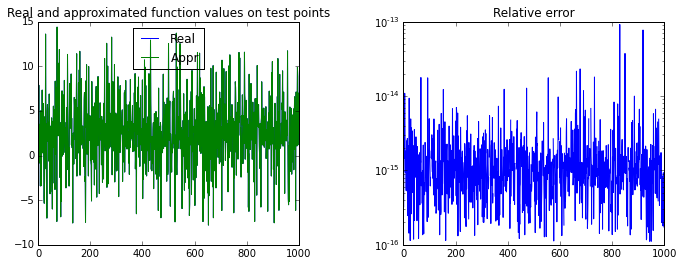

In [9]:
gs = gridspec.GridSpec(1, 2)
gs.update(left=0.05, right=1.5, wspace=0.4)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax1.set_title('Real and approximated function values on test points')
ax2.set_title('Relative error')
ax1.plot(np.arange(poi_num)+1, f_real, label='Real') 
ax1.plot(np.arange(poi_num)+1, f_calc, label='Appr')
ax2.plot(np.arange(poi_num)+1, np.abs((f_real-f_calc)/f_real))
ax1.legend(loc='best'); ax2.semilogy(); plt.show()